## Open AI Gym - Blackjack RL Monte Carlo
By Nathan Hutchins

In this project I am going to explore the Blackjack-v0 environment created by Open AIs gym library. https://www.gymlibrary.ml/environments/toy_text/blackjack/

I will be using Monte Carlo Reinforcement Learning to train an agent to play blackjack. I will not teach the agent any rules of the game, or any strategies. The goal of this project is to see how well the agent can learn on it's own and to see if it can reach a standard winning percentage that is common with a basic Blackjcak strategy. A common Blackjack strategy will achieve a win rate roughly around 40-42%. So this is our target! 

For the video example, please click here: https://youtu.be/RbyIOQ2IE_w

First input everything we need.

In [3]:
import numpy as np
from collections import defaultdict
import gym
import matplotlib.pyplot as plt
import sys
import json

--- 
### Example
Below is an example of how the environment works. You can see that we are given an action space and environment tuple. The action space is the number of possible actions to take. In the Blackjack environment there are two options, hit or stand; A 1 will represent hit (get another card), and a 0 will represet stand (don't get another card). The tuple that we get back from env.reset is the state of the environment. We can see we are given the players total, the dealers total, and if the player has an Ace card or not. 

In [4]:
# Make the environment 
env = gym.make("Blackjack-v0")

In [9]:
# States
player_sum, dealer_card, ace = env.reset()

# Actions
action_space = env.action_space.n

print(player_sum, dealer_card, ace)
print(action_space)

# Can represent the Q function states and actions
Q = defaultdict(lambda: np.zeros(2))
Q[env.reset()]

16 3 False
2


array([0., 0.])

---
# Creating our model!

I first need to create a Policy before I create the full Monte Carlo function that will run the whole project. A Policy in simple terms is blackbox that tells the agent what action to take from each possible state. There are multiple options and complex policies I can choose from. However, to keep things simple and understandable I have chosen a simple Epsilone-Greedy policy. This policy chooses between exploration and exploitation randomly. 

This function will need to take our Q function, current state, and current ϵ value.

$ \pi (a|s) ⟵  \begin{cases} 1 - ϵ + \frac{ϵ}{|A(s)|}  \text{if a maximizes} Q(s,a) \\ \frac{ϵ}{|A(s)|} \qquad \text{else} \end{cases}$

Ref: https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/





In [6]:
def epsilone_policy(Q, state, epsilon, display_probability=False):
    probs = [0.0, 0.0]

    # Get the most optimal action from this state (either 0 - stay, 1 - hit)
    optimal_action = np.argmax(Q[state])

    # Flip the action to get the non_optimal value
    non_optimal_action = 0 if optimal_action == 1 else 1
    
    """ Note: our number of actions is always going to be 2. Thus |A(s)| = 2"""
    # The top option from our policy above
    probs[optimal_action] = 1 - epsilon + (epsilon / 2)

    # The bottom option from our policy above
    probs[non_optimal_action] = epsilon / 2

    # choose an action randomly
    action = np.random.choice(np.arange(2), p = probs)
    
    # Debugging and Display purposes only 
    if display_probability:
      print(probs)
      if action:
        print(f"Action is {action}. Player hit.")
      else:
        print(f"Action is {action}. Player stands.")

    return action 

Now that we have a policy function, lets quickly test it to see it choose an action.

In [14]:
# testing epsiole_policy
action = epsilone_policy(Q, env.reset(), 0.8, True)

[0.6, 0.4]
Action is 0. Player stands.


Now that we have the policy working, I need a function to generate an episode that I can call while running the monte carlo function. This episode creating function needs pick an action in a current state (use the policy created above), record what happened, then either finish or continue to the next state if the game is not done. 

In BlackJack that means it gets two cards and the dealer gets one. It will then either hit or stand. If it goes over 21, the game is over and it will record the loss with a -1 reward. It it wins it will record the win with +1. If the game is still continuing it will play hit and play another round. 

In [15]:
def create_episode(Q, e, display=False):
    # Start each episode at a random state
    state = env.reset()
    episode = []
    
    while True: 
        # sampling actions using the Epsilon Greedy Policy 
        action = epsilone_policy(Q, state, e)

        # Step to the next state with this given action (update state at the same time)
        state, reward, done, _ = env.step(action)

        # Add information to episode
        episode.append((state, action, reward))
    
        if done == True:
            break
    
    # Debugging and Visualizer only
    if display:
      for i in episode:
        # Display hands
        print(f"Players Total: {i[0][0]}")
        print(f"Dealers Total: {i[0][1]}")

        # Check for ace
        if i[2]:
          print("Player has Ace!")

        # Display players action
        if i[1]:
          print("Player hit!")
        else:
          print("Player stays.")
        print("=====")

      # Display result of episode
      if episode[-1][2] == 1:
        print("Player wins!")
      elif episode[-1][2] == -1:
        print("Player lost...")
      else:
        print("Push (Draw game)")

    return episode 

Now we can create episodes! Let's gives this a quick test run and see what's happening. 

In [37]:
create_episode(Q, 0.7, True)

Players Total: 20
Dealers Total: 10
Player hit!
=====
Players Total: 28
Dealers Total: 10
Player has Ace!
Player hit!
=====
Player lost...


[((20, 10, False), 1, 0.0), ((28, 10, False), 1, -1.0)]

We can see that each index of the list contains the state, action, and result. Now with this set up, we can put it all together!!

In [38]:
def main(episodes, epsilon, epsilon_min, alpha, discount): 
    # Create a Q Function
    Q = defaultdict(lambda: np.zeros(2))

    # Keep track of every episodes rewards 
    episodes_rewards = []
    
    # Run for number of episodes provided 
    for episode in range(1, episodes + 1): 
      # Decay epsilon value each iteration
        epsilon = max(epsilon_min, epsilon * 0.9999)

        # Display what episode we are on ... 
        if episode % 1000 == 0:
          print("\rGames {}/{}:".format(episode, episodes), end="")
        
        if episode > 1000 and episode % 100 == 0:
          print("$", end ="")

        # Get information from each episode (game)
        states, actions, rewards = zip(*create_episode(Q, epsilon))
        rewards = np.array(rewards)
        episodes_rewards.append(sum(rewards))
        
        # Steps
        for i, state in enumerate(states):
          # Get the discount for the current state we are in and onwards
          discounts = np.array([discount ** i for i in range(len(rewards[i: ]))])
          returns = sum(rewards[i: ] * discounts)
          
          # Update our current Q(s,a) Function 
          Q[state][actions[i]] += alpha * (returns - Q[state][actions[i]])
          P = dict((state, np.argmax(q_value)) for state, q_value in Q.items())
        
    return Q, P, episodes_rewards

In [45]:
# Run the Monte Carlo Method with the following parameters
epsilon_min = 0.05
num_episodes = 1000000
Q, policy, rewards = main(num_episodes, 1, epsilon_min, 0.02, 1)

Games 1000000/1000000:$

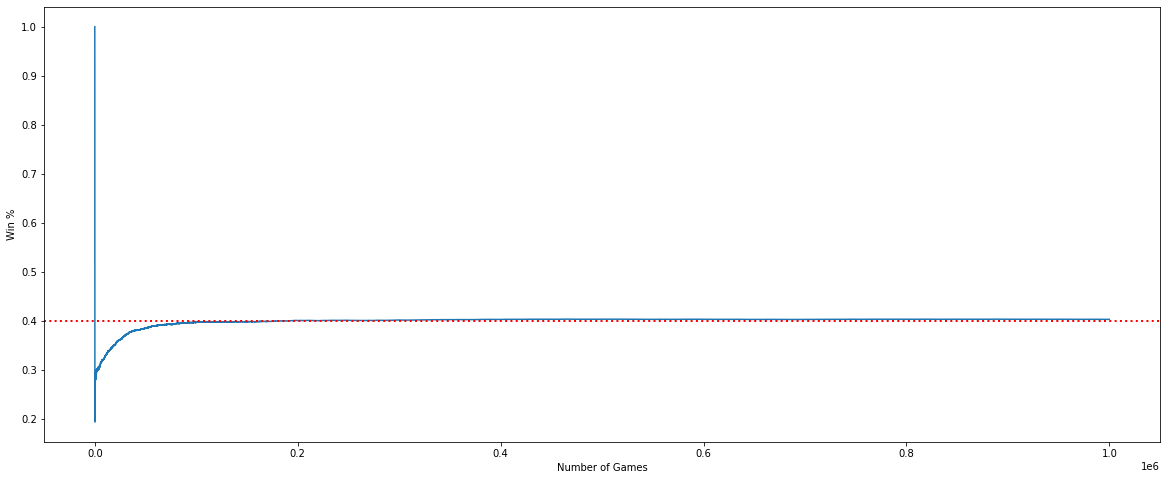

In [46]:
# We only want to count wins!
wins =  [0 if x == -1 else x for x in rewards]
wim_total= np.array(wins).cumsum()
win_ratio= wim_total / np.arange(1, num_episodes+1)

# Plot the graph!
plt.figure(figsize=(20, 8))
plt.plot(np.arange(1, num_episodes+1), win_ratio)
plt.axhline(y=0.4,linewidth= 2, color='r', linestyle= 'dotted')

# Label the graph
plt.xlabel("Number of Games")
plt.ylabel("Win %")
plt.show();

We can see that there is some fluctuation at the beginning of the training. This is when we are exploring so this is to be expected. Then the agent slowly starts to play consistently improving until the win ratio reaches roughly 40%. This is what we were expecting from the beginning. It looks like the AI agent learned how to play Blackjack with the same win percentage as an average Blackjack strategy!  

For fun, lets plot the results of the final 1000 games giving our agent $100 and giving +1 for a win and -1 for a lose.

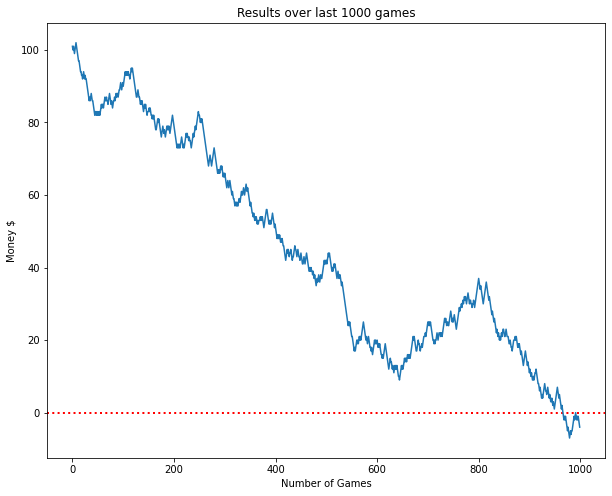

In [47]:
money = 100
count = []
for result in rewards[999000:]:
  if result == 1:
    money += 1

  elif result == -1:
    money -= 1
  
  count.append(money)

plt.figure(figsize=(10, 8))
plt.title("Results over last 1000 games")
plt.ylabel("Money $")
plt.xlabel("Number of Games")
plt.axhline(y=0,linewidth= 2, color='r', linestyle= 'dotted')
plt.plot(count);

Look at that slide!

I guess the take away from this project is that even a computer can't beat the 40-42% win rate. I'm sure there are other ML options that could improve this AI. But I am happy with the results! Overall it was a fun project. 